## 測試nnUNet training code
想要看出經過augmentation後，train的input長什麼樣子

In [1]:
import os
import socket
from typing import Union, Optional

import nnunetv2
import torch.cuda
import torch.distributed as dist
import torch.multiprocessing as mp
from batchgenerators.utilities.file_and_folder_operations import join, isfile, load_json
from nnunetv2.paths import nnUNet_preprocessed
from nnunetv2.run.load_pretrained_weights import load_pretrained_weights
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer
from nnunetv2.utilities.dataset_name_id_conversion import maybe_convert_to_dataset_name
from nnunetv2.utilities.find_class_by_name import recursive_find_python_class
from torch.backends import cudnn

In [2]:
def find_free_network_port() -> int:
    """Finds a free port on localhost.

    It is useful in single-node training when we don't want to connect to a real main node but have to set the
    `MASTER_PORT` environment variable.
    """
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(("", 0))
    port = s.getsockname()[1]
    s.close()
    return port

In [3]:
def get_trainer_from_args(dataset_name_or_id: Union[int, str],
                          configuration: str,
                          fold: int,
                          trainer_name: str = 'nnUNetTrainer',
                          plans_identifier: str = 'nnUNetPlans',
                          use_compressed: bool = False,
                          device: torch.device = torch.device('cuda')):
    # load nnunet class and do sanity checks
    nnunet_trainer = recursive_find_python_class(join(nnunetv2.__path__[0], "training", "nnUNetTrainer"),
                                                trainer_name, 'nnunetv2.training.nnUNetTrainer')
    if nnunet_trainer is None:
        raise RuntimeError(f'Could not find requested nnunet trainer {trainer_name} in '
                           f'nnunetv2.training.nnUNetTrainer ('
                           f'{join(nnunetv2.__path__[0], "training", "nnUNetTrainer")}). If it is located somewhere '
                           f'else, please move it there.')
    assert issubclass(nnunet_trainer, nnUNetTrainer), 'The requested nnunet trainer class must inherit from ' \
                                                    'nnUNetTrainer'

    # handle dataset input. If it's an ID we need to convert to int from string
    if dataset_name_or_id.startswith('Dataset'):
        pass
    else:
        try:
            dataset_name_or_id = int(dataset_name_or_id)
        except ValueError:
            raise ValueError(f'dataset_name_or_id must either be an integer or a valid dataset name with the pattern '
                             f'DatasetXXX_YYY where XXX are the three(!) task ID digits. Your '
                             f'input: {dataset_name_or_id}')

    # initialize nnunet trainer
    preprocessed_dataset_folder_base = join(nnUNet_preprocessed, maybe_convert_to_dataset_name(dataset_name_or_id))
    plans_file = join(preprocessed_dataset_folder_base, plans_identifier + '.json')
    plans = load_json(plans_file)
    dataset_json = load_json(join(preprocessed_dataset_folder_base, 'dataset.json'))
    nnunet_trainer = nnunet_trainer(plans=plans, configuration=configuration, fold=fold,
                                    dataset_json=dataset_json, unpack_dataset=not use_compressed, device=device)
    return nnunet_trainer

In [4]:
def maybe_load_checkpoint(nnunet_trainer: nnUNetTrainer, continue_training: bool, validation_only: bool,
                          pretrained_weights_file: str = None):
    if continue_training:
        expected_checkpoint_file = join(nnunet_trainer.output_folder, 'checkpoint_final.pth')
        if not isfile(expected_checkpoint_file):
            expected_checkpoint_file = join(nnunet_trainer.output_folder, 'checkpoint_latest.pth')
        # special case where --c is used to run a previously aborted validation
        if not isfile(expected_checkpoint_file):
            expected_checkpoint_file = join(nnunet_trainer.output_folder, 'checkpoint_best.pth')
        if not isfile(expected_checkpoint_file):
            print(f"WARNING: Cannot continue training because there seems to be no checkpoint available to "
                               f"continue from. Starting a new training...")
    elif validation_only:
        expected_checkpoint_file = join(nnunet_trainer.output_folder, 'checkpoint_final.pth')
        if not isfile(expected_checkpoint_file):
            raise RuntimeError(f"Cannot run validation because the training is not finished yet!")
    else:
        if pretrained_weights_file is not None:
            load_pretrained_weights(nnunet_trainer.network, pretrained_weights_file, verbose=True)
        expected_checkpoint_file = None

    if expected_checkpoint_file is not None:
        nnunet_trainer.load_checkpoint(expected_checkpoint_file)

In [5]:
def setup_ddp(rank, world_size):
    # initialize the process group
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

In [6]:
def cleanup_ddp():
    dist.destroy_process_group()

In [7]:
def run_ddp(rank, dataset_name_or_id, configuration, fold, tr, p, use_compressed, disable_checkpointing, c, val, pretrained_weights, npz, world_size):
    setup_ddp(rank, world_size)
    torch.cuda.set_device(torch.device('cuda', dist.get_rank()))

    nnunet_trainer = get_trainer_from_args(dataset_name_or_id, configuration, fold, tr, p,
                                           use_compressed)

    if disable_checkpointing:
        nnunet_trainer.disable_checkpointing = disable_checkpointing

    assert not (c and val), f'Cannot set --c and --val flag at the same time. Dummy.'

    maybe_load_checkpoint(nnunet_trainer, c, val, pretrained_weights)

    if torch.cuda.is_available():
        cudnn.deterministic = False
        cudnn.benchmark = True

    if not val:
        nnunet_trainer.run_training()

    nnunet_trainer.perform_actual_validation(npz)
    cleanup_ddp()

In [8]:
def run_training_show(dataset_name_or_id: Union[str, int],
                 configuration: str, fold: Union[int, str],
                 trainer_class_name: str = 'nnUNetTrainer',
                 plans_identifier: str = 'nnUNetPlans',
                 pretrained_weights: Optional[str] = None,
                 num_gpus: int = 1,
                 use_compressed_data: bool = False,
                 export_validation_probabilities: bool = False,
                 continue_training: bool = False,
                 only_run_validation: bool = False,
                 disable_checkpointing: bool = False,
                 device: torch.device = torch.device('cuda')):
    if isinstance(fold, str):
        if fold != 'all':
            try:
                fold = int(fold)
            except ValueError as e:
                print(f'Unable to convert given value for fold to int: {fold}. fold must bei either "all" or an integer!')
                raise e

    if num_gpus > 1:
        assert device.type == 'cuda', f"DDP training (triggered by num_gpus > 1) is only implemented for cuda devices. Your device: {device}"

        os.environ['MASTER_ADDR'] = 'localhost'
        if 'MASTER_PORT' not in os.environ.keys():
            port = str(find_free_network_port())
            print(f"using port {port}")
            os.environ['MASTER_PORT'] = port  # str(port)

        mp.spawn(run_ddp,
                 args=(
                     dataset_name_or_id,
                     configuration,
                     fold,
                     trainer_class_name,
                     plans_identifier,
                     use_compressed_data,
                     disable_checkpointing,
                     continue_training,
                     only_run_validation,
                     pretrained_weights,
                     export_validation_probabilities,
                     num_gpus),
                 nprocs=num_gpus,
                 join=True)
    else:
        nnunet_trainer = get_trainer_from_args(dataset_name_or_id, configuration, fold, trainer_class_name,
                                               plans_identifier, use_compressed_data, device=device)

        if disable_checkpointing:
            nnunet_trainer.disable_checkpointing = disable_checkpointing

        assert not (continue_training and only_run_validation), f'Cannot set --c and --val flag at the same time. Dummy.'

        maybe_load_checkpoint(nnunet_trainer, continue_training, only_run_validation, pretrained_weights)

        if torch.cuda.is_available():
            cudnn.deterministic = False
            cudnn.benchmark = True

        if not only_run_validation:
            nnunet_trainer.run_training()

        nnunet_trainer.perform_actual_validation(export_validation_probabilities)

In [9]:
if __name__ == '__main__':
    dataset_name_or_id = '74'
    configuration = '3d_fullres'
    fold = '0'
    num_gpus = 1
    trainer_class_name = 'nnUNetTrainer'
    plans_identifier = 'nnUNetPlans'
    use_compressed_data = False
    device = torch.device('cuda')
    
    #run_training(dataset_name_or_id, configuration, fold, args.tr, args.p, args.pretrained_weights,
    #             args.num_gpus, args.use_compressed, args.npz, args.c, args.val, args.disable_checkpointing,
    #             device=device)

    #run_training(dataset_name_or_id, configuration, fold)
    
    #下面把run_training完全展開來看
    if isinstance(fold, str):
        if fold != 'all':
            try:
                fold = int(fold)
            except ValueError as e:
                print(f'Unable to convert given value for fold to int: {fold}. fold must bei either "all" or an integer!')
                raise e
    
    if num_gpus > 1:
        assert device.type == 'cuda', f"DDP training (triggered by num_gpus > 1) is only implemented for cuda devices. Your device: {device}"

        os.environ['MASTER_ADDR'] = 'localhost'
        if 'MASTER_PORT' not in os.environ.keys():
            port = str(find_free_network_port())
            print(f"using port {port}")
            os.environ['MASTER_PORT'] = port  # str(port)
            
    else:
        nnunet_trainer = get_trainer_from_args(dataset_name_or_id, configuration, fold, trainer_class_name,
                                               plans_identifier, use_compressed_data, device=device)

        if torch.cuda.is_available():
            cudnn.deterministic = False
            cudnn.benchmark = True

        #if not only_run_validation:
        #    nnunet_trainer.run_training()

        #nnunet_trainer.perform_actual_validation(export_validation_probabilities)
        #這邊之後就用data, target來畫圖吧!!!
        data, target, positive = nnunet_trainer.run_training_ShowTraingData()

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

nnUNet-long-BigBatch-cosine-classifier
Loss: DC_and_CE_loss + CE_loss
DC_and_CE_loss => NewDC_loss_and_CE_loss
combnine FEMH!!! and Large Big Batch Size 1200!!!
batch_dice: False ddp False
weights!!!: [1.    0.5   0.25  0.125]
Loss: CE_loss
Loss: DC_loss
Loss: DC_loss0
Loss: DC_loss1
Loss: DC_loss2
Loss: DC_loss3

This is the configuration used by this training:
Configuration name: 3d_fullres
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [16, 32, 32], 'median_image_size_in_voxels': [16.0, 32.0, 

/home/chuan/anaconda3/envs/nnResUNet-long-BigBatch-cosine-classifier/lib/python3.9/site-packages/torch/onnx/utils.py:617: UserWarning: ONNX Preprocess - Removing mutation from node aten::add_ on block input: '150'. This changes graph semantics. (Triggered internally at ../torch/csrc/jit/passes/onnx/remove_inplace_ops_for_onnx.cpp:335.)
  _C._jit_pass_onnx_remove_inplace_ops_for_onnx(graph, module)
/home/chuan/anaconda3/envs/nnResUNet-long-BigBatch-cosine-classifier/lib/python3.9/site-packages/torch/onnx/utils.py:617: UserWarning: ONNX Preprocess - Removing mutation from node aten::add_ on block input: '156'. This changes graph semantics. (Triggered internally at ../torch/csrc/jit/passes/onnx/remove_inplace_ops_for_onnx.cpp:335.)
  _C._jit_pass_onnx_remove_inplace_ops_for_onnx(graph, module)
/home/chuan/anaconda3/envs/nnResUNet-long-BigBatch-cosine-classifier/lib/python3.9/site-packages/torch/onnx/utils.py:617: UserWarning: ONNX Preprocess - Removing mutation from node aten::add_ on blo

2025-04-11 11:05:20.296129: Unable to plot network architecture:
2025-04-11 11:05:20.296578: Unsupported: ONNX export of operator aten::feature_dropout, training mode. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues  [Caused by the value 'input.300 defined in (%input.300 : Float(1, 512, 4, 2, 2, strides=[8192, 16, 4, 2, 1], requires_grad=1, device=cuda:0), %346 : Float(512, strides=[1], requires_grad=0, device=cuda:0), %347 : Float(512, strides=[1], requires_grad=0, device=cuda:0) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002, training_mode=1](%input.296, %158, %159, %160, %161) # /home/chuan/anaconda3/envs/nnResUNet-long-BigBatch-cosine-classifier/lib/python3.9/site-packages/torch/nn/functional.py:2450:0
)' (type 'Tensor') in the TorchScript graph. The containing node has kind 'onnx::BatchNormalization'.] 
    (node defined in /home/chuan/anaconda3/envs/nnResUNet-long-Bi

2025-04-11 11:05:20.765626: 
2025-04-11 11:05:20.766138: Epoch 0
2025-04-11 11:05:20.766574: Current learning rate: 0.01
batch_id: 0


/home/chuan/anaconda3/envs/nnResUNet-long-BigBatch-cosine-classifier/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/chuan/anaconda3/envs/nnResUNet-long-BigBatch-cosine-classifier/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new

using pin_memory on device 0
Batch keys: dict_keys(['data', 'properties', 'positives', 'keys', 'target'])
data: torch.Size([2, 1, 16, 32, 32])


In [15]:
print('positive:', positive, positive.type())

positive: tensor([[0],
        [1]]) torch.LongTensor


In [11]:
#data是訓練的資料，data: torch.Size([600, 1, 16, 32, 32])
#target因為deep supervision，所以為一個list有4層，這邊取第一層與label對在一起看

In [12]:
from scipy import ndimage, interp  # pip install scipy
import scipy.stats
from sklearn.model_selection import train_test_split  # pip install scikit-learn
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, cohen_kappa_score
from skimage.util import montage  # pip install scikit-image
import skimage
import pickle
import cv2
import csv
import math
import datetime
from itertools import zip_longest
import json
import random
import numpy as np
import matplotlib
#%matplotlib notebook
%matplotlib inline
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt

In [13]:
def plot_multi_view(img, label):
    #先決定影像是否為正規化後，是的話就不用再做正規化, 先決定影像是否為4d，畫三張，原圖,label,疊圖
    #dim=3為標註123放在一起，dim=4為一標註一層，統一把標註轉為1層1個吧
    # 生成 1 到 100 之間的隨機正整數（包括 1 和 100）
    random_integer = random.randint(0, img.shape[0]-1)
    sample = img[random_integer,0,:,:,:]
    targe = label[random_integer,0,:,:,:]
    #為了展示正規化
    sample = (((sample - np.min(sample))/(np.max(sample) - np.min(sample)))*255).copy()
    sample[sample<0] = 0
    sample[sample>255] = 255
    #rands = np.random.randint(0, img.shape[-1], num) #multi view
    print('sample.shape:', sample.shape)
    for idx in range(sample.shape[0]):
        show = np.expand_dims(sample[idx,:,:], axis=-1).copy()
        y_i, x_i, z_i = show.shape
        show_one = show.copy()
        show = np.concatenate([show, show_one],2)
        show = np.concatenate([show, show_one],2)
        show = show.astype('uint8')
        show_label = np.zeros((y_i, x_i)).astype('uint8')
        show_IL = show.copy()

        y_nor1 = targe[idx,:,:]    
        y_color = (y_nor1*255).astype('uint8')
        y_th = cv2.Canny(y_color, 128, 256).copy()
        y_th = y_th.astype('uint8')

        y_c, x_c = np.where(y_nor1>0)
        if len(y_c) > 0:    
            show_label[y_c,x_c] = 1
        y_c, x_c = np.where(y_th>0)
        if len(y_c) > 0:    
            show_IL[y_c,x_c,0] = 255
            show_IL[y_c,x_c,1] = 0
            show_IL[y_c,x_c,2] = 0
                
        plt.style.use('default') #使用背景色，繪圖風格
        plt.figure(figsize=(20, 20)) #show 2view
        plt.subplot(1,3,1)
        plt.imshow(show)
        plt.title('Image', fontsize=20)
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(show_label, cmap='bone')
        plt.title('Label', fontsize=20)
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(show_IL)
        plt.title('ImgLabel', fontsize=20)
        plt.axis('off')        
        plt.show()

sample.shape: (16, 32, 32)


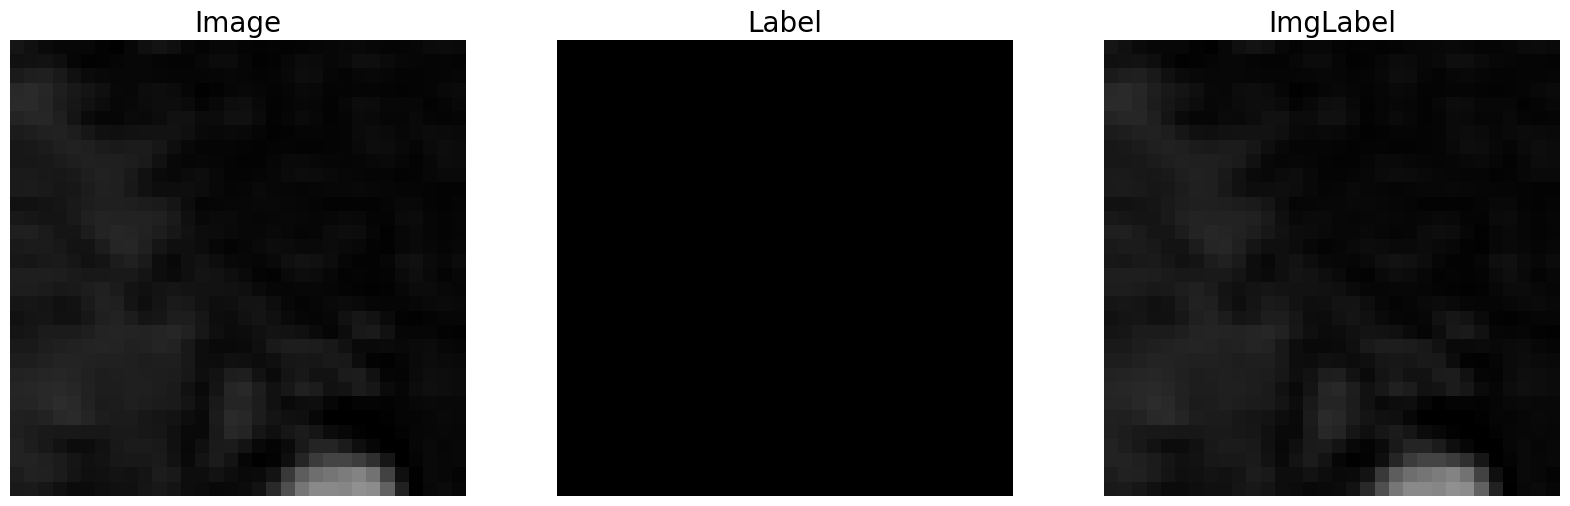

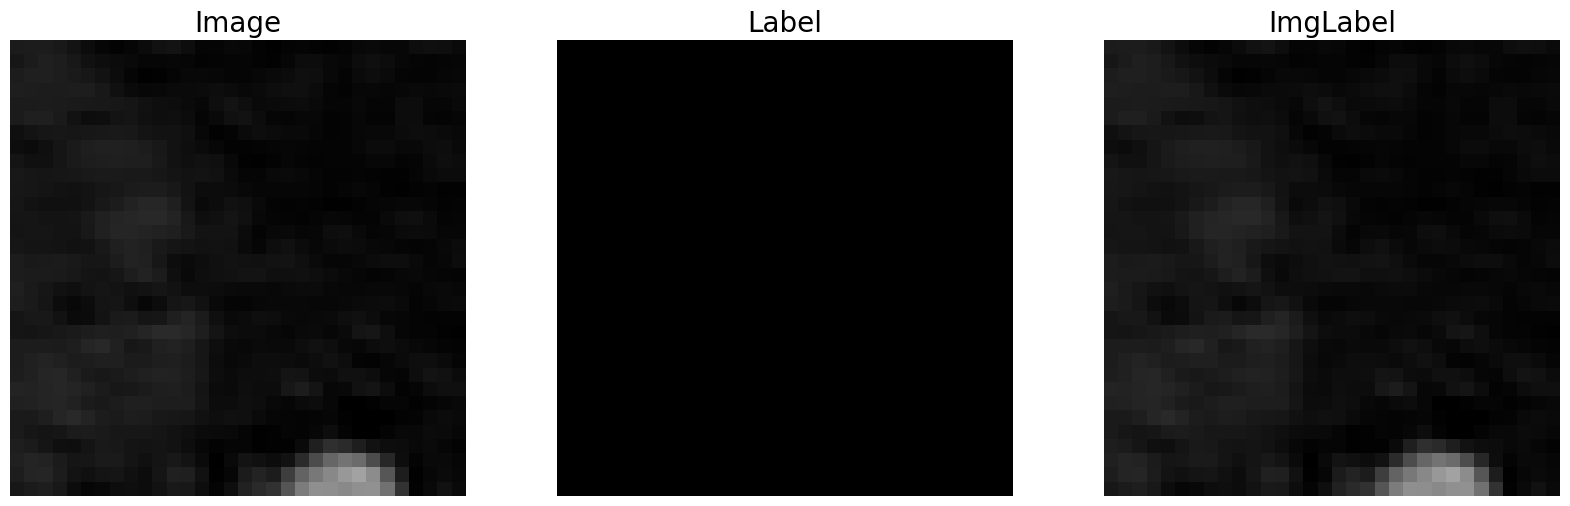

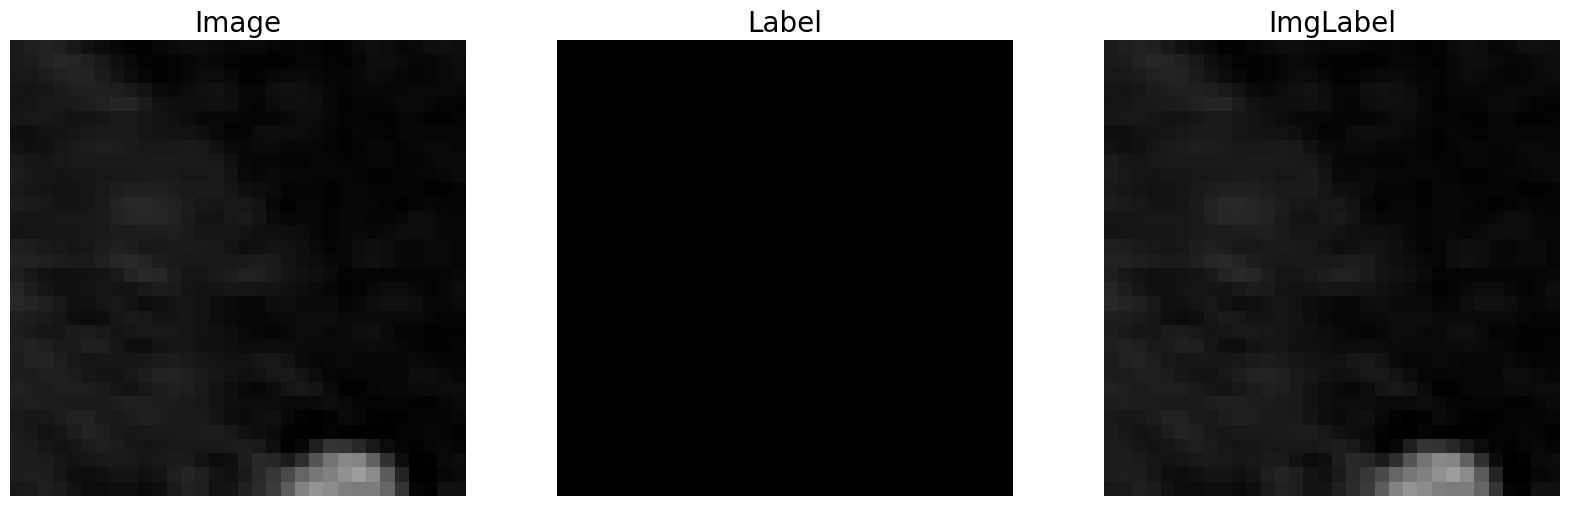

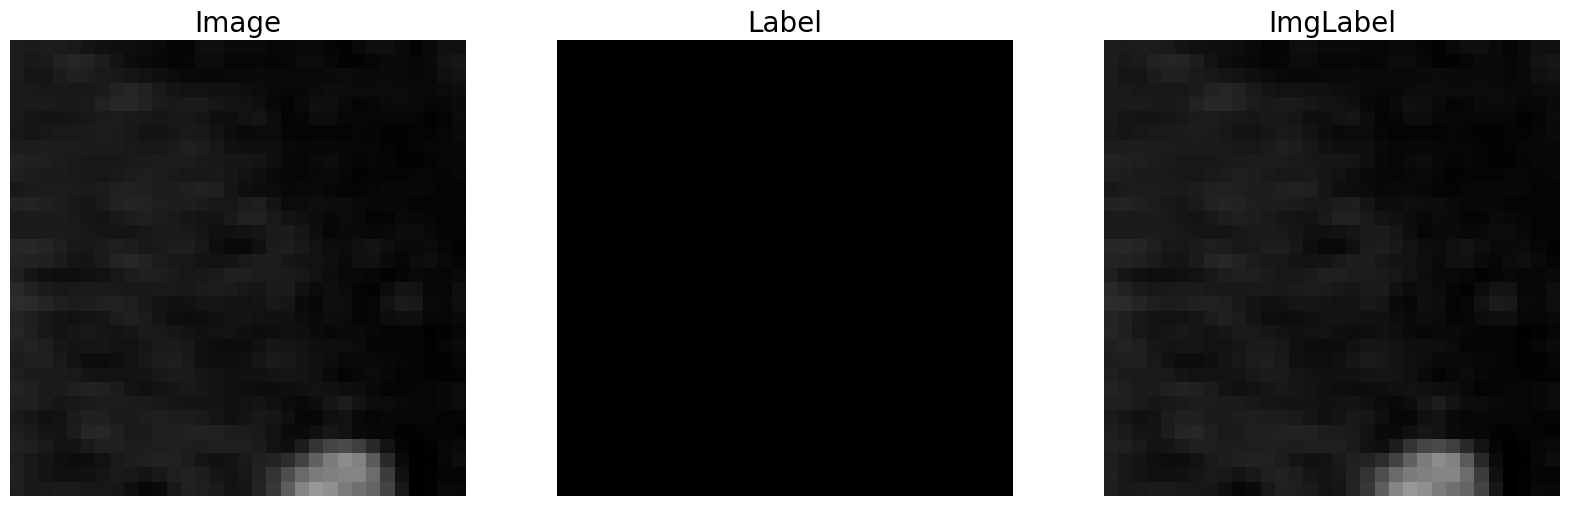

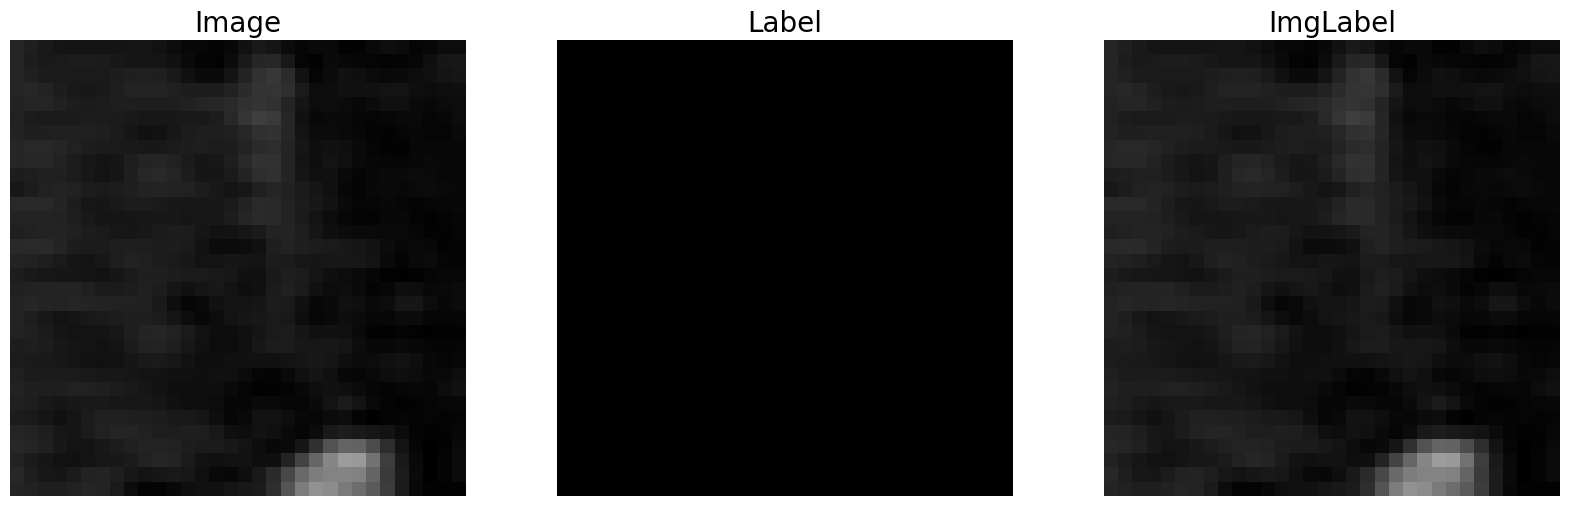

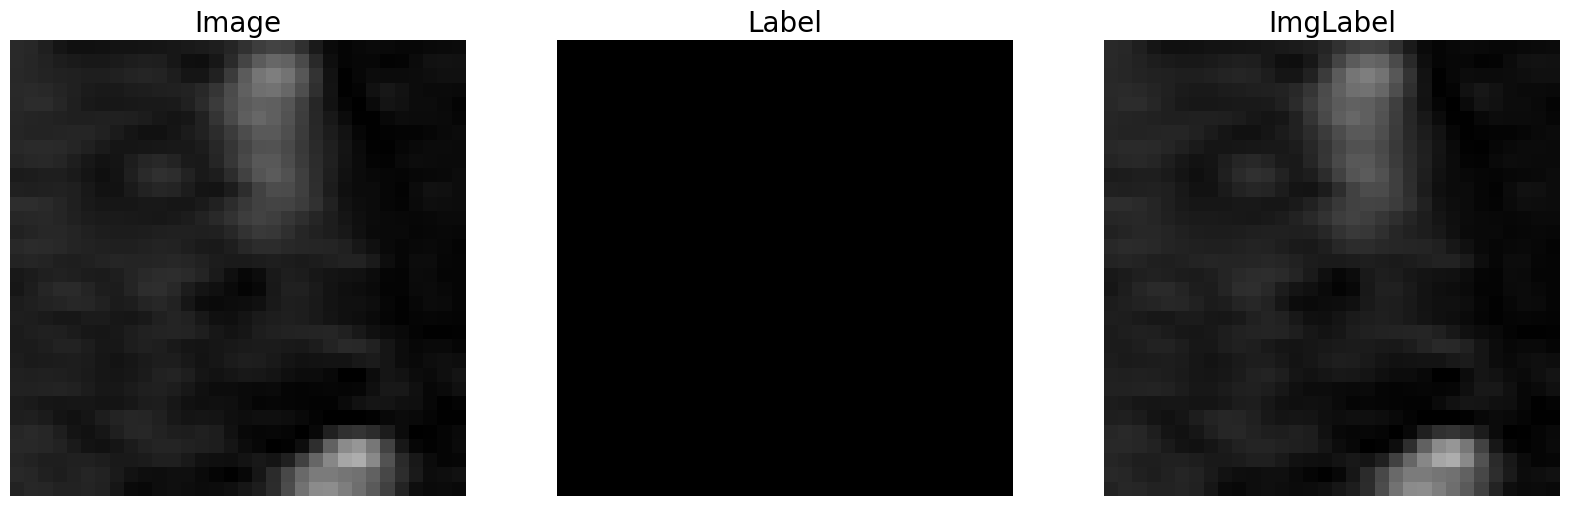

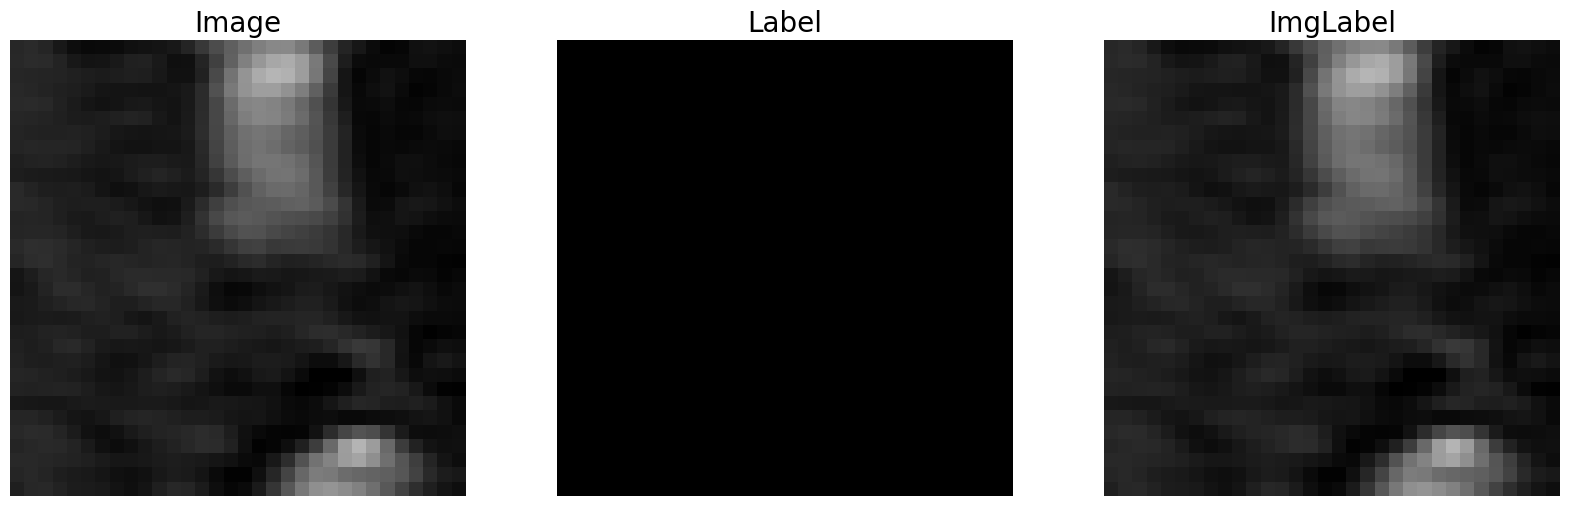

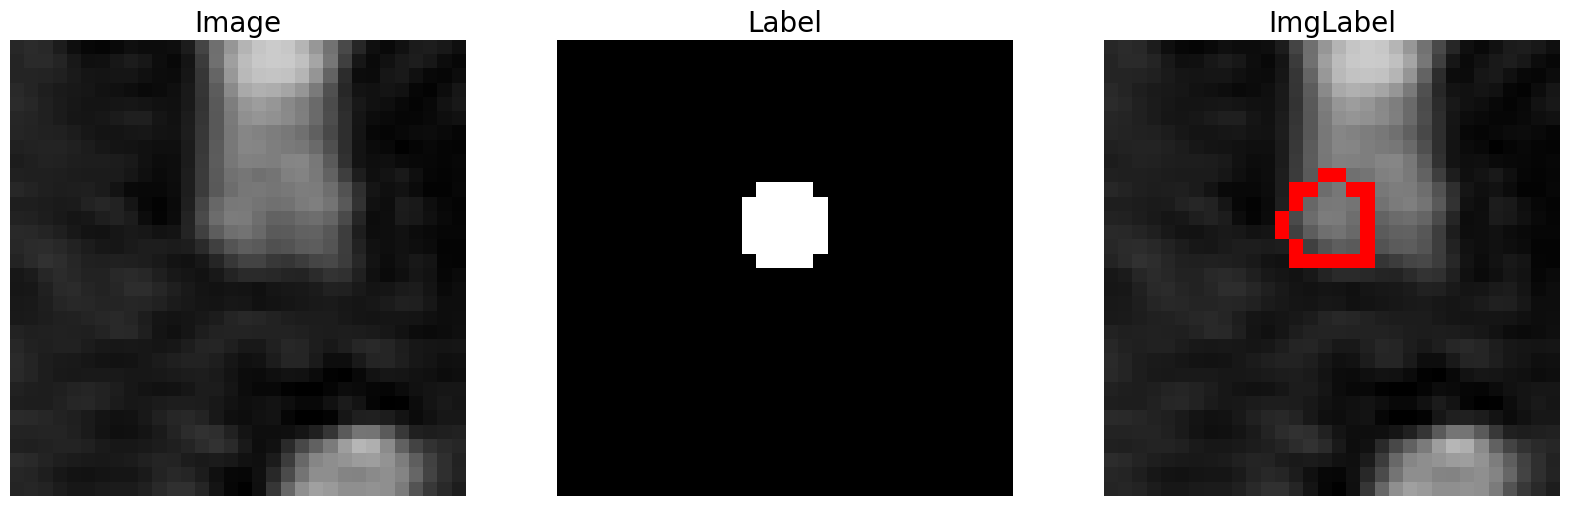

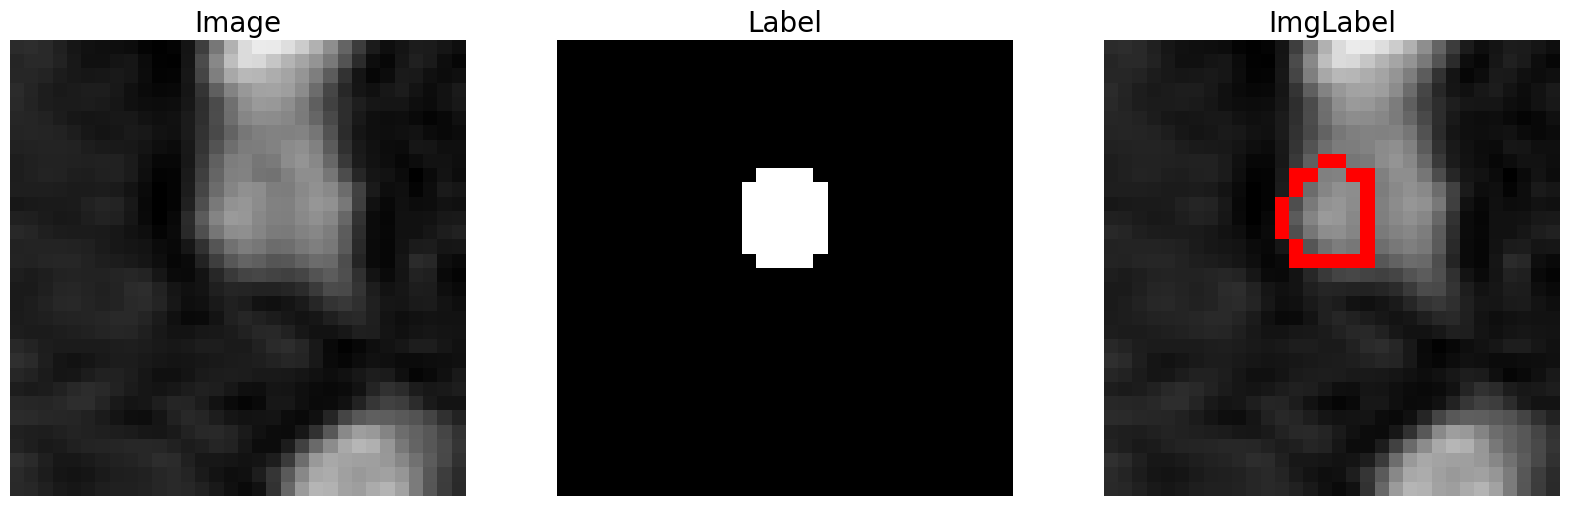

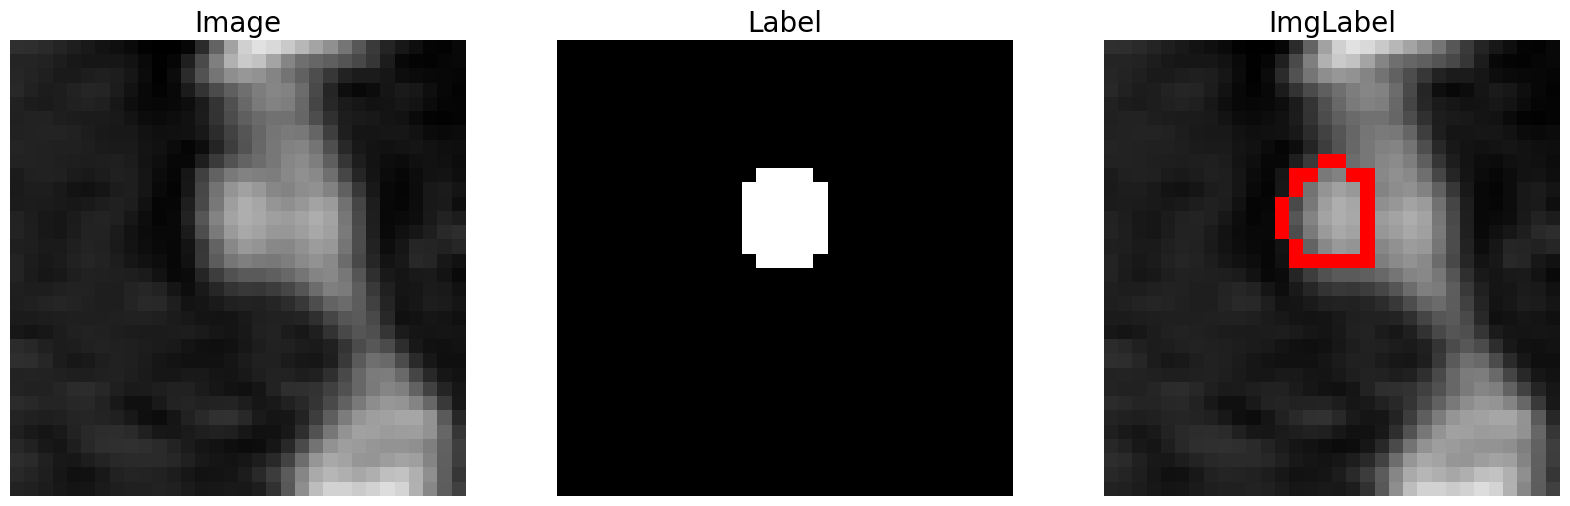

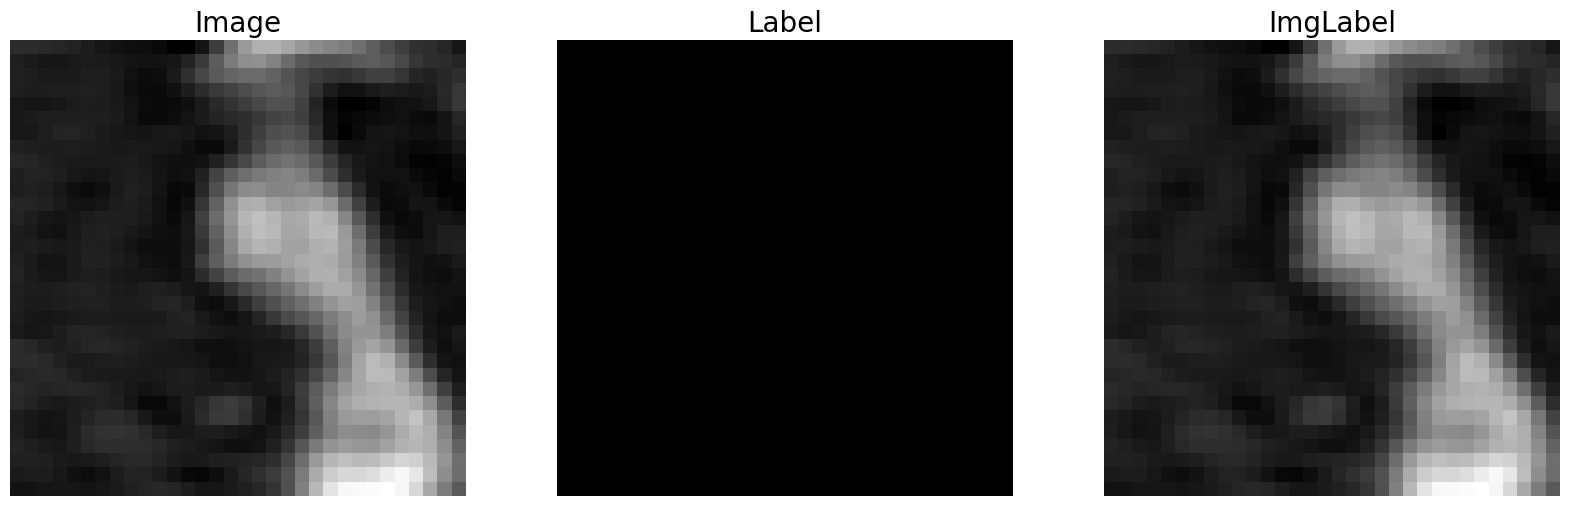

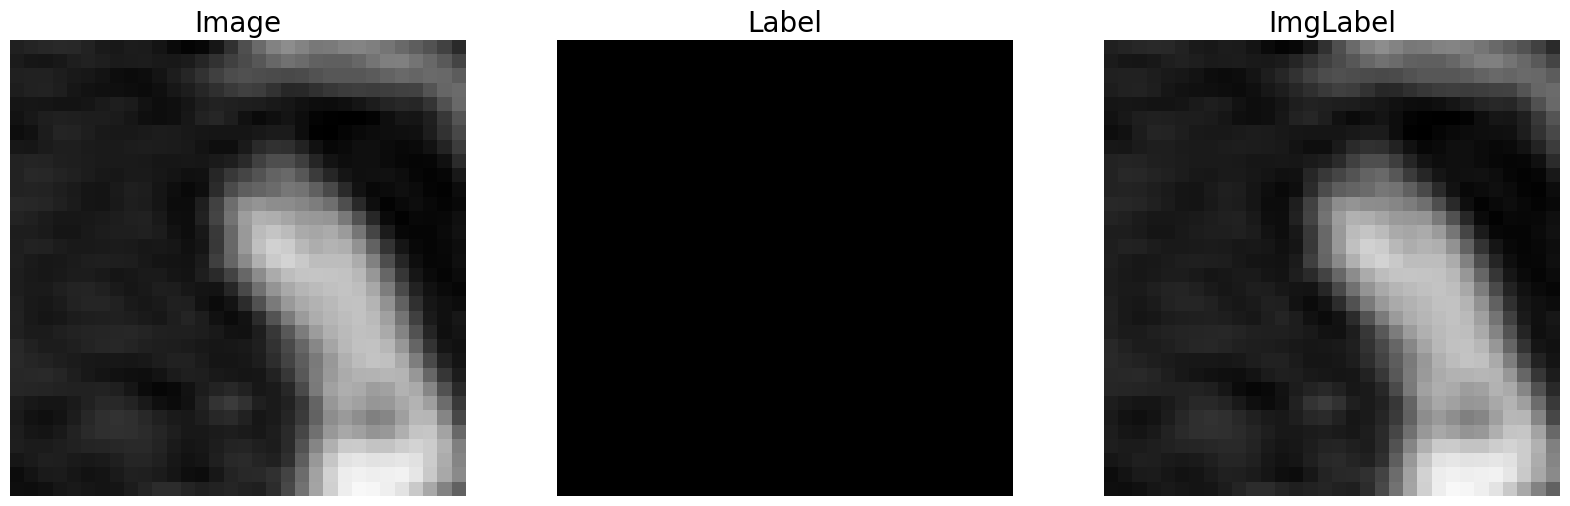

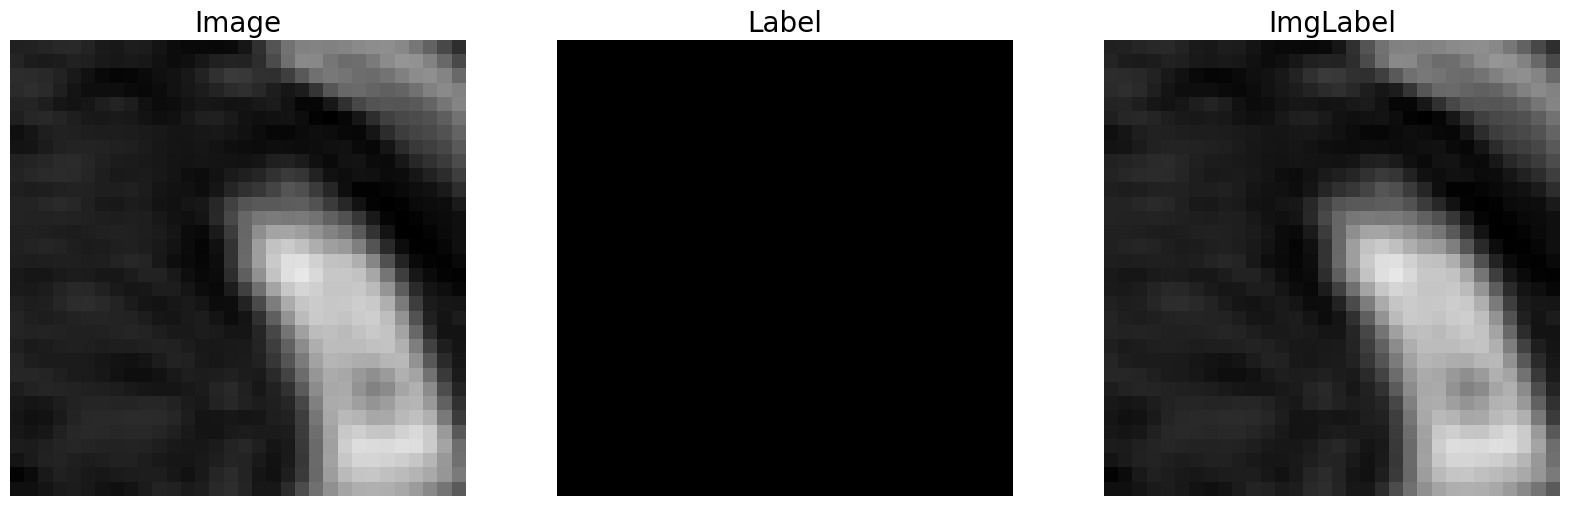

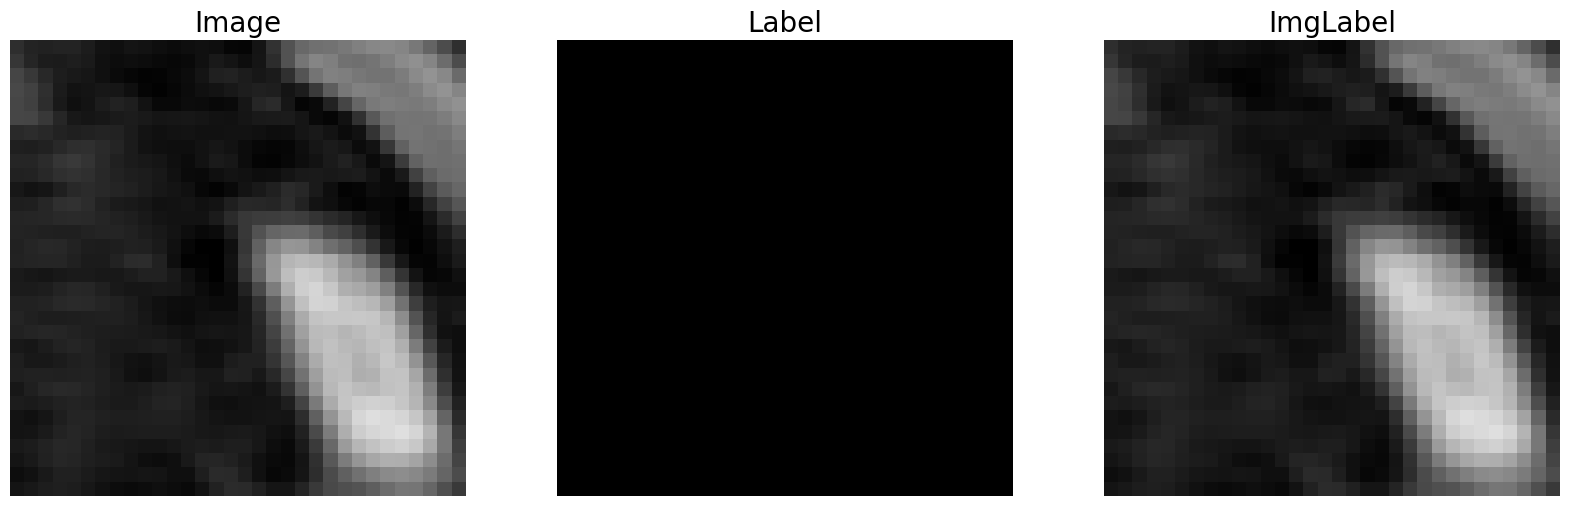

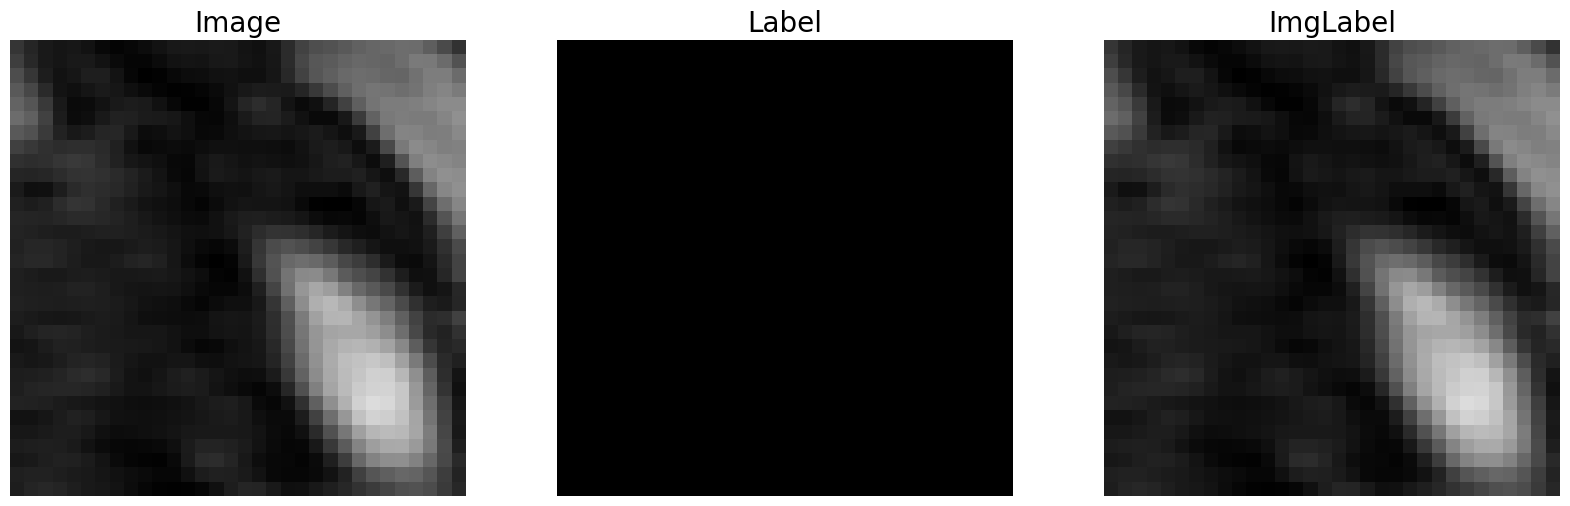

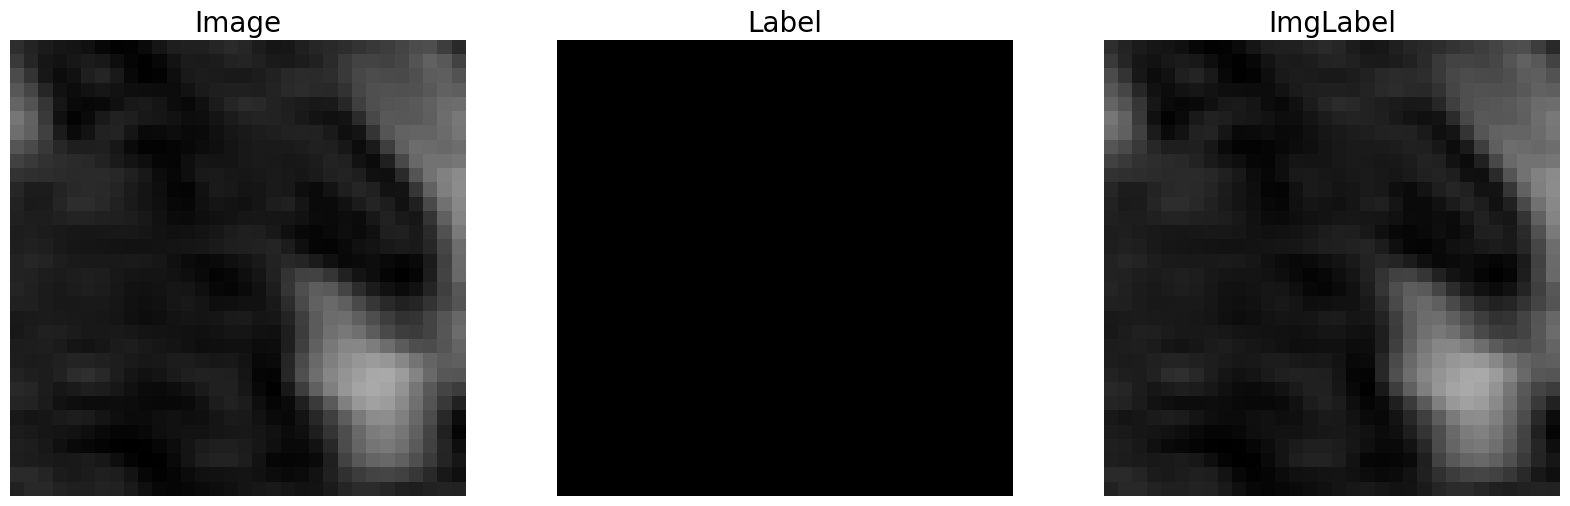

In [14]:
plot_multi_view(data.numpy(), target[0].numpy())